# PCA from GRM?
# Kazuyoshi Ishigaki
- PCA analysis using 1000G data
- to save time, only genotype data of Chr 1 were used
- Pruned (r2<0.1)
- Stratified genotype data by MAF

In [3]:
#.libPaths() 

In [5]:
# packages
library(magrittr) 
library(data.table)
library(ggsci)
library(ggplot2)
library(irlba)

In [23]:
options(repr.plot.width=5, repr.plot.height=4)

## I, Prepare input data

In [7]:
#read raw genotype data
d1 <- fread("gunzip -c 1000g_chr1_pruned_common.dosage.gz", header=T, stringsAsFactors = F,
            colClasses=c("character",rep("numeric",2504)))
d1 <- as.data.frame(d1)
colnames(d1) <- sapply(colnames(d1), function(x){unlist(strsplit(x,"_"))[1]})
geno <- as.matrix(d1[,2:ncol(d1)])
row.names(geno) <- as.character(d1[,1])

popinfo <- read.table("pop.info", header=F)
colnames(popinfo) <- c("ID","pop")

In [8]:
geno[1:4,1:4]
dim(geno)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,0,0,0,0
1_14930_A_G,1,1,1,1
1_15903_G_GC,1,1,0,1
1_51479_T_A,2,0,0,0


[1] 9713 2504

In [9]:
#centering 
geno_c <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    center <- x - Mean;
    return(center)
}))

In [10]:
geno_c[1:4,1:4]
dim(geno_c)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,-0.19009585,-0.19009585,-0.19009585,-0.19009585
1_14930_A_G,0.03554313,0.03554313,0.03554313,0.03554313
1_15903_G_GC,0.11781150,0.11781150,-0.88218850,0.11781150
1_51479_T_A,1.74361022,-0.25638978,-0.25638978,-0.25638978


[1] 9713 2504

In [11]:
#centering and scaling
geno_cs <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    SD <- sd(x);
    scaled <- ( x - Mean ) / SD;
    return(scaled)
}))

In [12]:
geno_cs[1:4,1:4]
dim(geno_cs)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,-0.4654439,-0.4654439,-0.4654439,-0.4654439
1_14930_A_G,0.1020155,0.1020155,0.1020155,0.1020155
1_15903_G_GC,0.1530940,0.1530940,-1.1463883,0.1530940
1_51479_T_A,3.0969511,-0.4553923,-0.4553923,-0.4553923


[1] 9713 2504

## 2, PCA using SNP x SNP covariance matrrix

In [56]:
#Sample (row) x SNP (col) matrix
X <- t(geno_cs)
dim(X) 

[1] 2504 9713

In [57]:
#SNP x SNP covariance matrix
XtX <- t(X) %*% X
dim(XtX) 

[1] 9713 9713

In [58]:
#calclate eigen vector and values: VERY SLOW!!!!
system.time( out <- eigen(XtX) )

   user  system elapsed 
497.139 111.149  92.110 

In [59]:
#calculate PC score from eigen vectors (genotype x eigen vector)
PC1 <-  X %*% out$vectors[,1] 
PC2 <-  X %*% out$vectors[,2] 

In [60]:
eigenvalue1 <- out$value[1]
eigenvalue2 <- out$value[2]

In [61]:
toppc <- data.frame(PC1,PC2)
row.names(toppc) <- colnames(geno_cs)
head(toppc)

,PC1,PC2
HG00096,16.62853,-21.22611
HG00097,12.97861,-21.86870
HG00099,13.29884,-25.21054
HG00100,13.65039,-23.09492
HG00101,15.25323,-24.95694
HG00102,14.43488,-22.23378


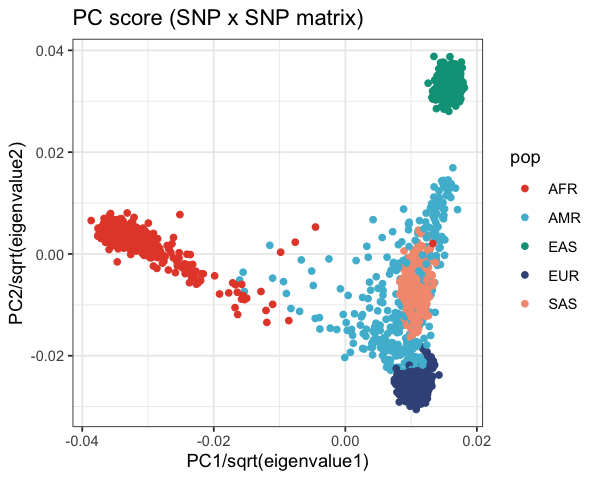

In [78]:
df <- data.frame(ID=row.names(toppc), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=PC1 / sqrt(eigenvalue1), y=PC2 / sqrt(eigenvalue2), color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="PC score (SNP x SNP matrix)")

save_df_snp_snp_mat <- df

## 3, PCA using Sample x Sample covariance matrrix (i.e. GRM)

In [63]:
# SNP (row) x Sample (col) matrix
X <- geno_cs
dim(X) 

[1] 9713 2504

In [64]:
#Sample x Sample covariance matrix
XtX <- t(X) %*% X
dim(XtX) 

[1] 2504 2504

In [65]:
#calclate eigen vector and values: ultra fast!!!!
system.time( out <- eigen(XtX) )

   user  system elapsed 
 10.685   7.828   3.324 

In [66]:
#Actually, it is NOT PC score. They are eigenvectors!!
Eig1 <-  out$vectors[,1] 
Eig2 <-  out$vectors[,2] 

In [67]:
toppc <- data.frame(Eig1,Eig2)
row.names(toppc) <- colnames(geno_cs)
head(toppc)

,Eig1,Eig2
HG00096,-0.012639622,-0.02467356
HG00097,-0.009865255,-0.02542051
HG00099,-0.010108666,-0.02930512
HG00100,-0.010375887,-0.02684589
HG00101,-0.011594234,-0.02901033
HG00102,-0.010972188,-0.02584489


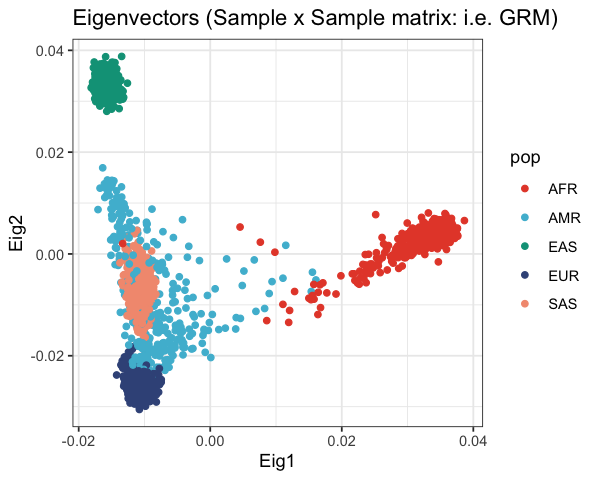

In [83]:
df <- data.frame(ID=row.names(toppc), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=Eig1, y=Eig2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="Eigenvectors (Sample x Sample matrix: i.e. GRM)")

save_df_sample_sample_mat <- df

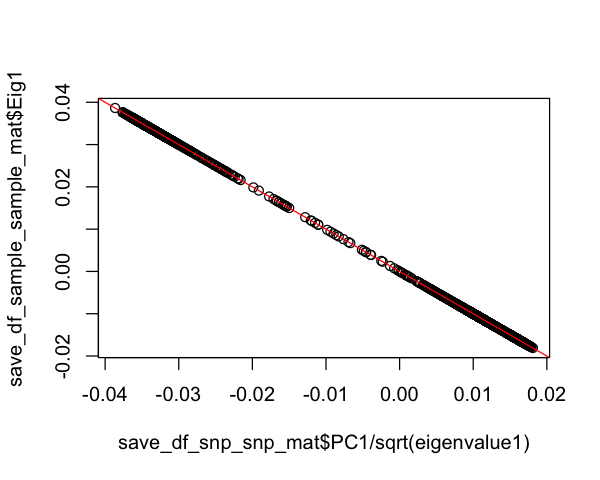

In [73]:
#let's compare 2 conditions: basically same!! (only the difference of sign)
plot(
    save_df_snp_snp_mat$PC1/sqrt(eigenvalue1),
    save_df_sample_sample_mat$Eig1
)
abline(a=0,b=-1,col="red")

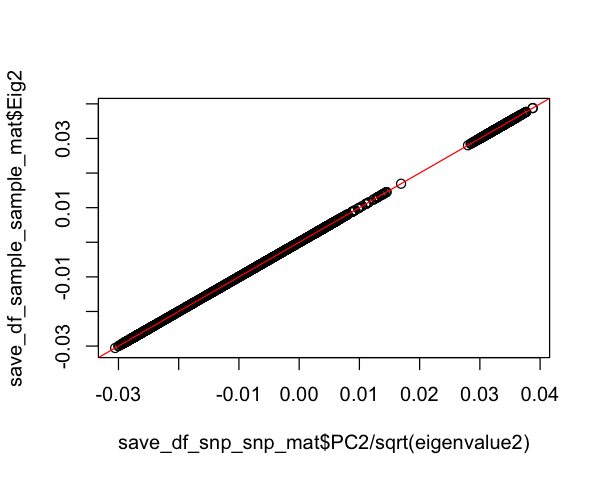

In [75]:
#let's compare 2 conditions: same!!
plot(
    save_df_snp_snp_mat$PC2/sqrt(eigenvalue2),
    save_df_sample_sample_mat$Eig2
)
abline(a=0,b=1,col="red")